In [1]:
import os
os.chdir('/mnt/cup/people/gs6614/U19-pipeline_python')

In [2]:
import datajoint as dj
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

Connect to the database using `dj_local_conf.json` file or use the `U19-pipeline_python/notebooks/00-Datajoint-configuration.ipynb` notebook in developer mode. 

For user mode, follow the instructions below to connect to the database:
```
dj.config['database.host'] = 'datajoint00.pni.princeton.edu'
dj.config['database.user'] = '<username>'
dj.config['database.password'] = getpass.getpass()
```

Check if the connection was established using the following command

In [3]:
dj.conn()

Connecting gs6614@datajoint00.pni.princeton.edu:3306


DataJoint connection (connected) gs6614@datajoint00.pni.princeton.edu:3306

## Schemas and tables

+ The current workflow is composed of multiple database schemas, each of them corresponds to a module within `u19_pipeline`

In [4]:
# modules within original u19_pipeline
from u19_pipeline import lab, subject, imaging_rec, recording

# modules defined in DataJoint Calcium Imaging element, installed to u19_pipeline
from u19_pipeline.imaging_element import scan_element, imaging_element

+ In U19 pipeline, `scan_element` and `imaging_element` stores information about the scan and results respectively
+ `imaging`: module defined in u19_pipeline. The contents in the tables of this module were processed by suite2p or caiman in Python using [DataJoint Element Calcium Imaging](https://github.com/datajoint/element-calcium-imaging).
+ `scan_element` and `imaging_element`: modules defined with [DataJoint element calcium imaging](https://github.com/datajoint/element-calcium-imaging). 

Let's check which schema are we connected to! Currently we are connected to the u19_imaging_rec_element. For developement use, one would want to connect to a different database (not the original one). The developer can make update `database.prefix` in `dj_local_conf.json` file to reflect this. 

In [7]:
imaging_element.schema

Schema `u19_imaging_rec_element`

+ The table classes in the module corresponds to a table in the schema in the database. Here, Activity is a table (which in python language was defined as a class).
+ We already have some data populated in the tables, let us display the available processed data in a few downstream tables

In [10]:
imaging_element.Activity.Trace()

recording_process_id Unique number assigned to each processing job for a recording unit,scan_id,paramset_idx,curation_id,extraction_method,mask,fluo_channel 0-based indexing,activity_trace
23,0,3,1,suite2p_deconvolution,0,0,=BLOB=
23,0,3,1,suite2p_deconvolution,1,0,=BLOB=
23,0,3,1,suite2p_deconvolution,2,0,=BLOB=
23,0,3,1,suite2p_deconvolution,3,0,=BLOB=
23,0,3,1,suite2p_deconvolution,4,0,=BLOB=
23,0,3,1,suite2p_deconvolution,5,0,=BLOB=
23,0,3,1,suite2p_deconvolution,6,0,=BLOB=


We can select the desired entries from the database. In datajoint words, selection or filtration is called as restriction. We will learn about this more.

In [13]:
imaging_element.Activity.Trace() & 'recording_process_id=26'

recording_process_id Unique number assigned to each processing job for a recording unit,scan_id,paramset_idx,curation_id,extraction_method,mask,fluo_channel 0-based indexing,activity_trace
26,0,3,1,suite2p_deconvolution,0,0,=BLOB=
26,0,3,1,suite2p_deconvolution,1,0,=BLOB=
26,0,3,1,suite2p_deconvolution,2,0,=BLOB=
26,0,3,1,suite2p_deconvolution,3,0,=BLOB=
26,0,3,1,suite2p_deconvolution,4,0,=BLOB=
26,0,3,1,suite2p_deconvolution,5,0,=BLOB=
26,0,3,1,suite2p_deconvolution,6,0,=BLOB=


In [17]:
imaging_element.Activity.Trace() & 'recording_process_id=26' & 'mask=2'

recording_process_id Unique number assigned to each processing job for a recording unit,scan_id,paramset_idx,curation_id,extraction_method,mask,fluo_channel 0-based indexing,activity_trace
26,0,3,1,suite2p_deconvolution,2,0,=BLOB=


## Visualizations

Once the desired entry is isolated, we can download or fetch data from the database to perform functions like plotting

In [41]:
trace = (imaging_element.Activity.Trace() & 'recording_process_id=26' & 'mask=2').fetch('activity_trace')

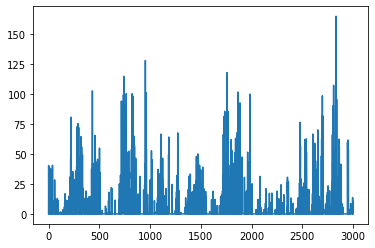

In [42]:
plt.plot(trace[0])

What happens if we use fetch1 instead of fetch?

In [32]:
trace = (imaging_element.Activity.Trace() & 'recording_process_id=26' & 'mask=2').fetch1('activity_trace')

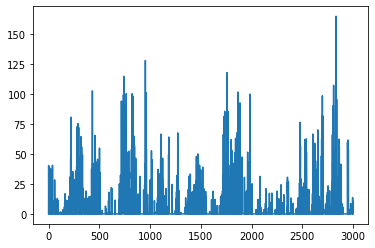

In [40]:
plt.plot(trace)

In [43]:
fluo2 = (imaging_element.Fluorescence.Trace() & 'recording_process_id=26' & 'mask=2').fetch1('fluorescence')
fluo3 = (imaging_element.Fluorescence.Trace() & 'recording_process_id=26' & 'mask=3').fetch1('fluorescence')

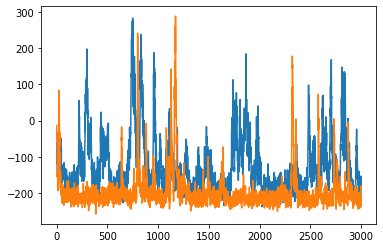

In [44]:
plt.plot(fluo2)
plt.plot(fluo3)

## Visualize masks

The segmented masks are in the table `imaging_element.Segmentation.Mask`

In [45]:
key = {'recording_process_id':26, 'mask':3}

In [46]:
imaging_element.Segmentation.Mask() & key

recording_process_id Unique number assigned to each processing job for a recording unit,scan_id,paramset_idx,curation_id,mask,segmentation_channel 0-based indexing,mask_npix number of pixels in ROIs,mask_center_x center x coordinate in pixel,mask_center_y center y coordinate in pixel,mask_center_z center z coordinate in pixel,mask_xpix x coordinates in pixels,mask_ypix y coordinates in pixels,mask_zpix z coordinates in pixels,mask_weights weights of the mask at the indices above
26,0,3,1,3,0,163,28,143,0,=BLOB=,=BLOB=,=BLOB=,=BLOB=


In [47]:
scan_key = (scan_element.Scan & key).fetch('KEY')

In [48]:
scan_key

[{'recording_process_id': 26, 'scan_id': 0}]

In [52]:
px_height, px_width = (scan_element.ScanInfo().Field & scan_key).fetch1('px_height', 'px_width')
masks = (imaging_element.Segmentation.Mask & scan_key & 'curation_id=1').fetch()

In [53]:
img = np.full((px_height, px_width), np.nan)

In [54]:
for mask in masks:
    img[mask['mask_xpix'], mask['mask_ypix']] = mask['mask_weights']

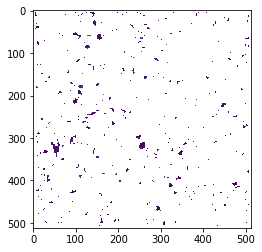

In [55]:
plt.imshow(img)

+ By importing the modules for the first time, the schemas and tables will be created inside the database.

+ Once created, importing modules will not create schemas and tables again, but the existing schemas/tables can be accessed and manipulated by the modules.

#### We learnt steps to download / fetch and plot data stored in datajoint tables. Now let's explore the pipeline and see how data is flowing

## DataJoint tools to explore schemas and tables

+ `dj.list_schemas()`: list all schemas a user has access to in the current database

In [9]:
dj.list_schemas()

['aarusso_pipeline',
 'aarusso_puffs',
 'aarusso_puffs_py',
 'aarusso_tutorial',
 'abondy_tutorial',
 'ahoag_BrainSharer',
 'ahoag_admin_demo',
 'ahoag_admin_flask_demo',
 'ahoag_admin_test',
 'ahoag_appcore_copy',
 'ahoag_brainsharer_test',
 'ahoag_celery_test',
 'ahoag_debugjoin',
 'ahoag_lab_test',
 'ahoag_lightsheet_copy',
 'ahoag_lightsheet_demo',
 'ahoag_lightsheet_test',
 'ahoag_microscope_demo',
 'ahoag_microscope_demo_old',
 'ahoag_microscope_test',
 'ahoag_mouselight_test',
 'ahoag_puffs_acquisition_demo',
 'ahoag_puffs_behavior_demo',
 'ahoag_puffs_lab_demo',
 'ahoag_spockadmin_copy',
 'ahoag_spockadmin_demo',
 'ahoag_spockadmin_test',
 'ahoag_subject_test',
 'ahoag_test',
 'ahoag_test2',
 'ahoag_test3',
 'ahoag_test4',
 'ahoag_test5',
 'ahoag_test6',
 'ahoag_test_db',
 'ahoag_test_django',
 'ahoag_tutorial',
 'alvaros_ephys',
 'alvaros_ephys_rec',
 'alvaros_imaging_rec',
 'alvaros_recording',
 'brody_2pdemo',
 'brody_trash',
 'brody_tutorial2',
 'brody_tutorial3',
 'brody_t

+ `dj.Diagram()`: plot tables and dependencies in a schema. 

/usr/people/gs6614/.conda/envs/U19-pipeline_python/lib/python3.8/inspect.py:350: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  value = getattr(object, key)
/usr/people/gs6614/.conda/envs/U19-pipeline_python/lib/python3.8/inspect.py:350: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  value = getattr(object, key)
/usr/people/gs6614/.conda/envs/U19-pipeline_python/lib/python3.8/inspect.py:350: FutureWarning: pandas.UInt64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  value = getattr(object, key)


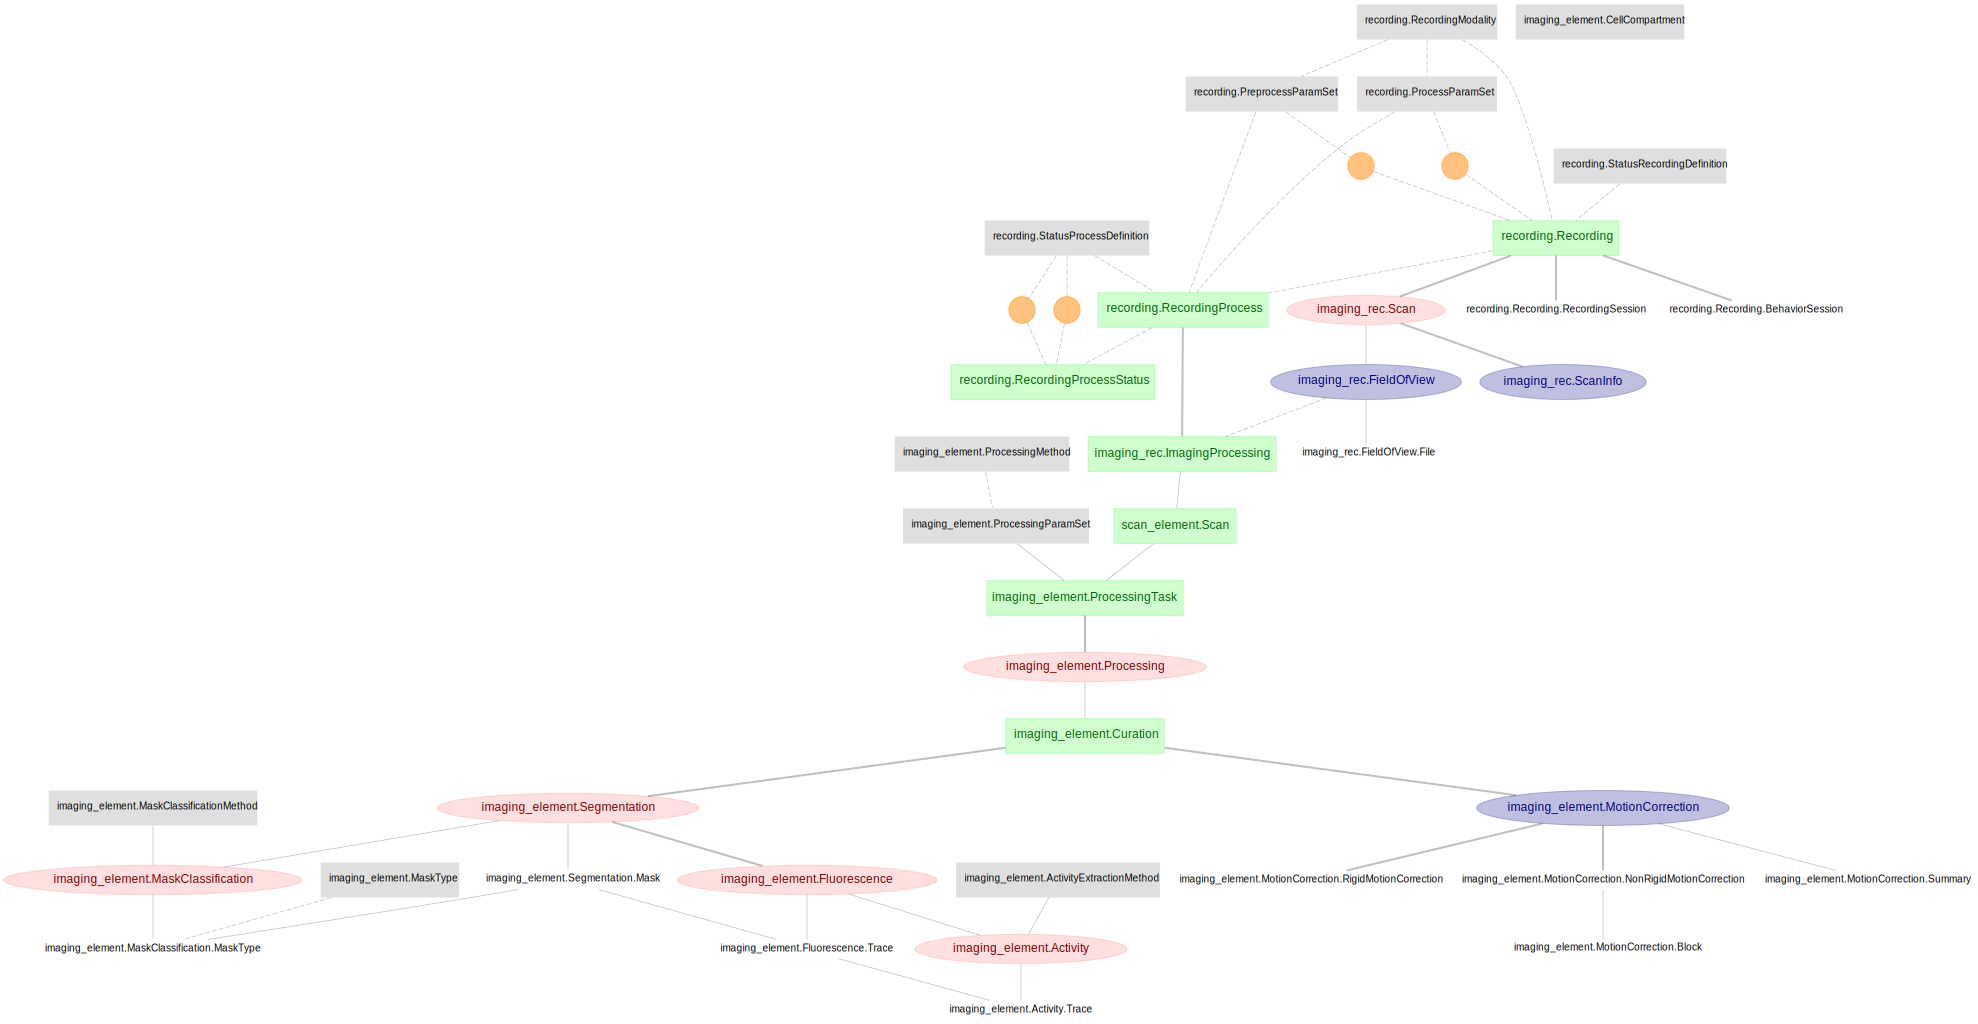

In [19]:
dj.Diagram(recording) + dj.Diagram(imaging_element) + dj.Diagram(imaging_rec) 

/usr/people/gs6614/.conda/envs/U19-pipeline_python/lib/python3.8/inspect.py:350: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  value = getattr(object, key)
/usr/people/gs6614/.conda/envs/U19-pipeline_python/lib/python3.8/inspect.py:350: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  value = getattr(object, key)
/usr/people/gs6614/.conda/envs/U19-pipeline_python/lib/python3.8/inspect.py:350: FutureWarning: pandas.UInt64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  value = getattr(object, key)


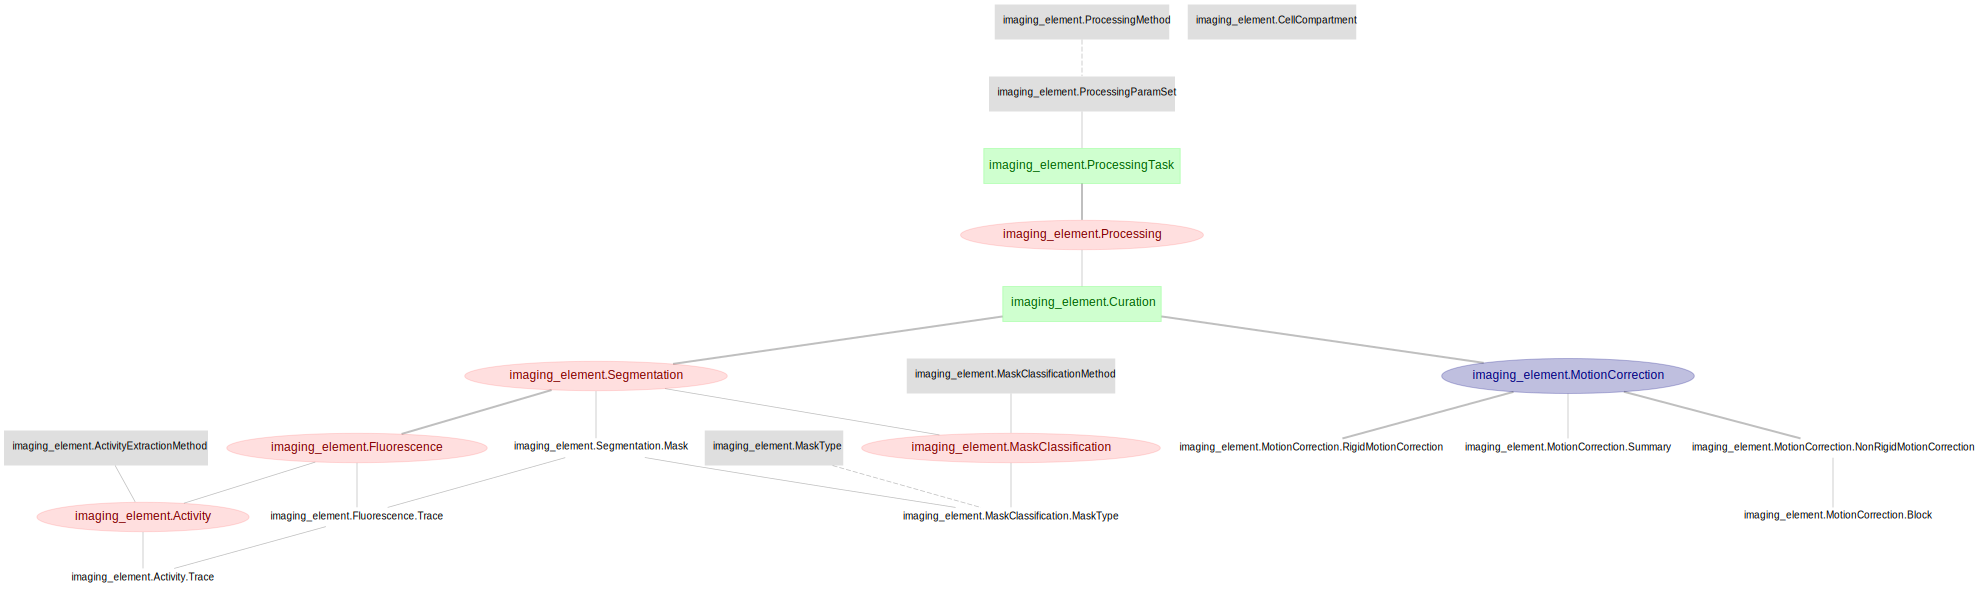

In [13]:
dj.Diagram(imaging_element)

/usr/people/gs6614/.conda/envs/U19-pipeline_python/lib/python3.8/inspect.py:350: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  value = getattr(object, key)
/usr/people/gs6614/.conda/envs/U19-pipeline_python/lib/python3.8/inspect.py:350: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  value = getattr(object, key)
/usr/people/gs6614/.conda/envs/U19-pipeline_python/lib/python3.8/inspect.py:350: FutureWarning: pandas.UInt64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  value = getattr(object, key)


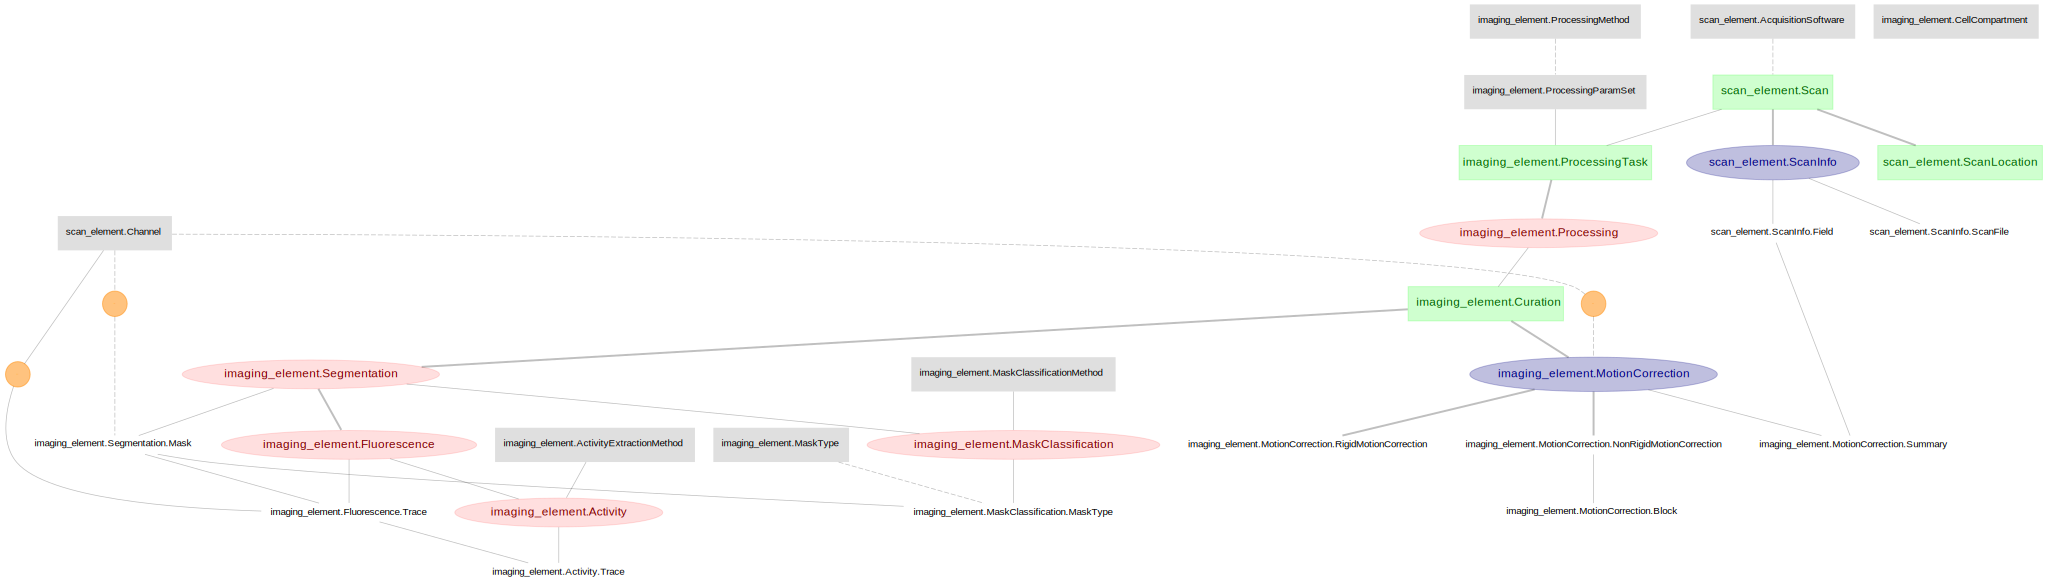

In [19]:
dj.Diagram(scan_element) + dj.Diagram(imaging_element)

/usr/people/gs6614/.conda/envs/U19-pipeline_python/lib/python3.8/inspect.py:350: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  value = getattr(object, key)
/usr/people/gs6614/.conda/envs/U19-pipeline_python/lib/python3.8/inspect.py:350: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  value = getattr(object, key)
/usr/people/gs6614/.conda/envs/U19-pipeline_python/lib/python3.8/inspect.py:350: FutureWarning: pandas.UInt64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  value = getattr(object, key)


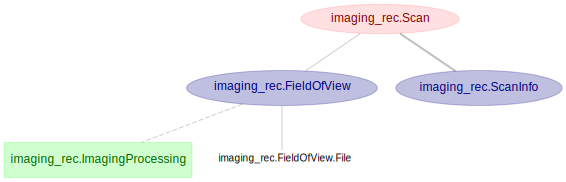

In [12]:
# plot diagram for all tables in a schema
dj.Diagram(imaging_rec)

**Table tiers**: 

Manual table: green box, manually inserted table, expect new entries daily, e.g. `Subject`, `Session`.

Lookup table: gray box, pre inserted table, commonly used for general facts or parameters. e.g. `Strain`, `ProcessingMethod`, `ProcessingParamSet`.

Imported table: blue oval, auto-processing table, the processing depends on the importing of external files. e.g. populte table `Processing` requires output files from Suite2p or CaImAn.   

Computed table: red circle, auto-processing table, the processing does not depend on files external to the database, commonly used for data analyses, such as the tables `Fluorescence` and `Activity`, whose results are computed from the data in the table `Segmentation`.      

Part table: plain text, as an appendix to the master table, all the part entries of a given master entry represent a intact set of the master entry. e.g. `Mask` from a `Segmentation`.

**Dependencies**:  

One-to-one primary: thick solid line, share the exact same primary key, meaning the child table inherits all the primary key fields from the parent table as its own primary key.    

One-to-many primary: thin solid line, inherit the primary key from the parent table, but have additional field(s) as part of the primary key as well.     

Secondary dependency: dashed line, the child table inherits the primary key fields from parent table as its own secondary attribute.

+ `describe()`: show table definition with foreign key references.

In [ ]:
imaging_element.Processing.describe()

-> imaging_element.ProcessingTask
---
processing_time      : datetime                     # time of generation of this set of processed, segmented results



+ `heading`: show attribute definitions regardless of foreign key references

In [ ]:
imaging_element.Processing.heading

# 
subject_fullname     : varchar(64)                  # username_mouse_nickname
session_date         : date                         # date of experiment
session_number       : int                          # number
scan_id              : int                          # 
paramset_idx         : smallint                     # 
---
processing_time      : datetime                     # time of generation of this set of processed, segmented results

In [ ]:
scan_element.Scan().describe();

-> acquisition.Session
scan_id              : int                          
---
-> `u19_lab`.`equipment`
-> scan_element.AcquisitionSoftware
scan_notes=""        : varchar(4095)                # free-notes



In [ ]:
subject.Subject.describe();

subject_fullname     : varchar(64)                  # username_mouse_nickname
---
subject_nickname     : varchar(16)                  
-> lab.User
genomics_id=null     : int                          # number from the facility
sex="Unknown"        : enum('Male','Female','Unknown') # sex
dob=null             : date                         # birth date
head_plate_mark=null : blob                         # little drawing on the head plate for mouse identification
-> lab.Location
-> [nullable] lab.Protocol
-> [nullable] subject.Line
subject_description="" : varchar(255)                 # description
initial_weight=null  : float                        



## Flow of data

In [5]:
recording_process_id = 26

In [6]:
rec_process_key = dict(recording_process_id=recording_process_id)
rec_process_str_key = 'recording_process_id_'+str(recording_process_id)

In [7]:
#Get fov key
rec_process = (imaging_rec.ImagingProcessing & rec_process_key).fetch1() 
#INFO: Table ImagingProcessing contains recording_process_id, recording_id and fov
fov_key = rec_process.copy()
fov_key.pop('recording_process_id')

26

In [8]:
fov_key

{'recording_id': 13, 'fov': 1}

In [9]:
#Recording process extra info
recording_process_info = (lab.Location * recording.RecordingProcess * recording.Recording & rec_process_key).fetch(
    'acquisition_type', 'preprocess_paramset_idx', 'process_paramset_idx', as_dict=True)

In [10]:
recording_process_info

[{'acquisition_type': '2photon',
  'preprocess_paramset_idx': 4,
  'process_paramset_idx': 2}]

In [11]:
imaging_element.Curation() & recording_process_info

recording_process_id Unique number assigned to each processing job for a recording unit,scan_id,paramset_idx,curation_id,curation_time time of generation of this set of curated results,"curation_output_dir output directory of the curated results, relative to root data directory",manual_curation has manual curation been performed on this result?,curation_note
23,0,3,1,2022-02-21 09:39:06,emdia/emdia_gps8/20210208/ROI01_z1/suite2p,0,
23,0,3,2,2022-02-21 09:39:06,emdia/emdia_gps8/20210208/ROI01_z1/suite2p,0,
23,0,3,3,2022-02-21 09:39:06,emdia/emdia_gps8/20210208/ROI01_z1/suite2p,0,
23,0,3,4,2022-02-21 09:39:06,emdia/emdia_gps8/20210208/ROI01_z1/suite2p,0,
23,0,3,5,2022-02-21 09:39:06,emdia/emdia_gps8/20210208/ROI01_z1/suite2p,0,
23,0,3,6,2022-02-21 09:39:06,emdia/emdia_gps8/20210208/ROI01_z1/suite2p,0,
23,0,3,7,2022-02-21 09:39:06,emdia/emdia_gps8/20210208/ROI01_z1/suite2p,0,


In [12]:
imaging_element.MotionCorrection()

recording_process_id Unique number assigned to each processing job for a recording unit,scan_id,paramset_idx,curation_id,motion_correct_channel 0-based indexing
23,0,3,1,0
24,0,3,1,0
25,0,3,1,0
26,0,3,1,0
28,0,3,1,0


In [13]:
imaging_element.Segmentation()

recording_process_id Unique number assigned to each processing job for a recording unit,scan_id,paramset_idx,curation_id
23,0,3,1
24,0,3,1
25,0,3,1
26,0,3,1
28,0,3,1


In [14]:
imaging_element.Segmentation.Mask()

recording_process_id Unique number assigned to each processing job for a recording unit,scan_id,paramset_idx,curation_id,mask,segmentation_channel 0-based indexing,mask_npix number of pixels in ROIs,mask_center_x center x coordinate in pixel,mask_center_y center y coordinate in pixel,mask_center_z center z coordinate in pixel,mask_xpix x coordinates in pixels,mask_ypix y coordinates in pixels,mask_zpix z coordinates in pixels,mask_weights weights of the mask at the indices above
23,0,3,1,0,0,43,55,415,0,=BLOB=,=BLOB=,=BLOB=,=BLOB=
23,0,3,1,1,0,96,376,451,0,=BLOB=,=BLOB=,=BLOB=,=BLOB=
23,0,3,1,2,0,195,87,425,0,=BLOB=,=BLOB=,=BLOB=,=BLOB=
23,0,3,1,3,0,186,98,296,0,=BLOB=,=BLOB=,=BLOB=,=BLOB=
23,0,3,1,4,0,257,457,72,0,=BLOB=,=BLOB=,=BLOB=,=BLOB=
23,0,3,1,5,0,89,60,346,0,=BLOB=,=BLOB=,=BLOB=,=BLOB=
23,0,3,1,6,0,382,55,88,0,=BLOB=,=BLOB=,=BLOB=,=BLOB=


In [15]:
imaging_element.Fluorescence.Trace()

recording_process_id Unique number assigned to each processing job for a recording unit,scan_id,paramset_idx,curation_id,mask,fluo_channel 0-based indexing,fluorescence fluorescence trace associated with this mask,neuropil_fluorescence Neuropil fluorescence trace
23,0,3,1,0,0,=BLOB=,=BLOB=
23,0,3,1,1,0,=BLOB=,=BLOB=
23,0,3,1,2,0,=BLOB=,=BLOB=
23,0,3,1,3,0,=BLOB=,=BLOB=
23,0,3,1,4,0,=BLOB=,=BLOB=
23,0,3,1,5,0,=BLOB=,=BLOB=
23,0,3,1,6,0,=BLOB=,=BLOB=


In [16]:
imaging_element.Activity()

recording_process_id Unique number assigned to each processing job for a recording unit,scan_id,paramset_idx,curation_id,extraction_method
23,0,3,1,suite2p_deconvolution
24,0,3,1,suite2p_deconvolution
25,0,3,1,suite2p_deconvolution
26,0,3,1,suite2p_deconvolution
28,0,3,1,suite2p_deconvolution


## Other operations

We learnt about selecting or filtering entries from the table, let us look at other types of operations that can be performed

In [21]:
scan_element.Scan()

recording_process_id Unique number assigned to each processing job for a recording unit,scan_id,scanner,acq_software,scan_notes free-notes
23,0,mesoscope,ScanImage,
24,0,mesoscope,ScanImage,
25,0,mesoscope,ScanImage,
26,0,2photon,ScanImage,
28,0,2photon,ScanImage,


In [23]:
imaging_element.Activity.Trace()

recording_process_id Unique number assigned to each processing job for a recording unit,scan_id,paramset_idx,curation_id,extraction_method,mask,fluo_channel 0-based indexing,activity_trace
23,0,3,1,suite2p_deconvolution,0,0,=BLOB=
23,0,3,1,suite2p_deconvolution,1,0,=BLOB=
23,0,3,1,suite2p_deconvolution,2,0,=BLOB=
23,0,3,1,suite2p_deconvolution,3,0,=BLOB=
23,0,3,1,suite2p_deconvolution,4,0,=BLOB=
23,0,3,1,suite2p_deconvolution,5,0,=BLOB=
23,0,3,1,suite2p_deconvolution,6,0,=BLOB=


In [24]:
scan_element.ScanInfo & imaging_element.Activity.Trace

recording_process_id Unique number assigned to each processing job for a recording unit,scan_id,nfields number of fields,nchannels number of channels,ndepths Number of scanning depths (planes),nframes number of recorded frames,nrois number of ROIs (see scanimage's multi ROI imaging),x (um) ScanImage's 0 point in the motor coordinate system,y (um) ScanImage's 0 point in the motor coordinate system,z (um) ScanImage's 0 point in the motor coordinate system,fps (Hz) frames per second - Volumetric Scan Rate,bidirectional true = bidirectional scanning,usecs_per_line microseconds per scan line,fill_fraction raster scan temporal fill fraction (see scanimage)
23,0,1,1,1,48000,0,0.0,0.0,0.0,12.3581,1,41.4969,0.712867
24,0,1,1,1,48000,0,0.0,0.0,0.0,12.3581,1,41.4969,0.712867
25,0,1,1,1,48000,0,0.0,0.0,0.0,12.3581,1,41.4969,0.712867
26,0,1,1,1,72664,0,nan,nan,nan,28.8143,1,63.0981,0.712867
28,0,1,1,1,85590,0,nan,nan,nan,28.715,1,63.0861,0.712867


In [29]:
imaging_element.Activity.Trace * imaging_element.Fluorescence.Trace

recording_process_id Unique number assigned to each processing job for a recording unit,scan_id,paramset_idx,curation_id,extraction_method,mask,fluo_channel 0-based indexing,activity_trace,fluorescence fluorescence trace associated with this mask,neuropil_fluorescence Neuropil fluorescence trace
23,0,3,1,suite2p_deconvolution,0,0,=BLOB=,=BLOB=,=BLOB=
23,0,3,1,suite2p_deconvolution,1,0,=BLOB=,=BLOB=,=BLOB=
23,0,3,1,suite2p_deconvolution,2,0,=BLOB=,=BLOB=,=BLOB=
23,0,3,1,suite2p_deconvolution,3,0,=BLOB=,=BLOB=,=BLOB=
23,0,3,1,suite2p_deconvolution,4,0,=BLOB=,=BLOB=,=BLOB=
23,0,3,1,suite2p_deconvolution,5,0,=BLOB=,=BLOB=,=BLOB=
23,0,3,1,suite2p_deconvolution,6,0,=BLOB=,=BLOB=,=BLOB=


In [32]:
imaging_element.Fluorescence.Trace.proj('fluorescence')

recording_process_id Unique number assigned to each processing job for a recording unit,scan_id,paramset_idx,curation_id,mask,fluo_channel 0-based indexing,fluorescence fluorescence trace associated with this mask
23,0,3,1,0,0,=BLOB=
23,0,3,1,1,0,=BLOB=
23,0,3,1,2,0,=BLOB=
23,0,3,1,3,0,=BLOB=
23,0,3,1,4,0,=BLOB=
23,0,3,1,5,0,=BLOB=
23,0,3,1,6,0,=BLOB=


In [37]:
# scan_element.ScanInfo.proj(..., nframes_new = 'sum(nframes, 10)')

### We can now go into the details of the built of the pipeline